### 1. Reading image data
This script uses [Middlebury Computer Vision dataset](http://vision.middlebury.edu/mview/data/) with a render of "Temple of the Dioskouroi" in Agrigento, Sicily.  
It contains 312 views sampled on a hemisphere. There are also files with camera parameters and angles for each image.

*DataReader* is a class that can read data i.e. frames and camera parameters from the data set.

In [1]:
from DataReader import DataReader
dataReader = DataReader(datasetDirectory="data/temple/")

Found 312 images in data/temple/ dataset.


In [2]:
frame1 = dataReader.readFrame(1, convertToRGB=True)
frame2 = dataReader.readFrame(2, convertToRGB=True)

### 2. Feature extraction
Extracting features from both images using ORB (oriented BRIEF) keypoint detector and descriptor extractor.

In [3]:
import cv2

extractorORB = cv2.ORB_create()
keypoints1, descriptors1 = extractorORB.detectAndCompute(frame1, mask=None)
keypoints2, descriptors2 = extractorORB.detectAndCompute(frame2, mask=None)

In [4]:
import matplotlib.pyplot as plt

keypointsImage = cv2.drawKeypoints(frame1, keypoints1, None)
plt.imshow(keypointsImage)
plt.show()

<Figure size 640x480 with 1 Axes>

### 3. Feature matching


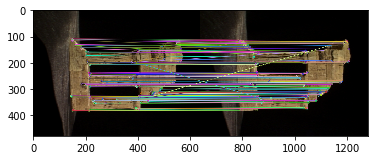

In [5]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = matcher.match(queryDescriptors=descriptors1, trainDescriptors=descriptors2)
matches = sorted(matches, key = lambda x:x.distance)

matchesImage = cv2.drawMatches(frame1, keypoints1, frame2, keypoints2, matches, None, flags=2)
plt.imshow(matchesImage)
plt.show()

In [6]:
frame1Pts = [keypoints1[m.queryIdx].pt for m in matches]
frame2Pts = [keypoints2[m.trainIdx].pt for m in matches]
print(frame1Pts[:3])
print(frame2Pts[:3])

[(555.8400268554688, 113.76000213623047), (555.6000366210938, 114.00000762939453), (408.0000305175781, 291.6000061035156)]
[(556.4160766601562, 114.04801177978516), (555.8400268554688, 113.76000213623047), (408.0000305175781, 290.4000244140625)]


### 4. Reading camera parameters

In [7]:
K1, R1, t1 = dataReader.readCameraParams(1)
K2, R2, t2 = dataReader.readCameraParams(2)

# print("Camera intrinsic matrix K =\n", K1)
# print("Rotation matrix R =\n", R1)
# print("Translation vector t =\n", t1)

In [8]:
import numpy as np

P1 = np.hstack((R1, np.transpose(t1)))
P2 = np.hstack((R2, np.transpose(t2)))
print(P1)
print(P2)

[[ 0.01551372  0.99884344 -0.04550951 -0.05998548]
 [ 0.99922239 -0.0171375  -0.03550953  0.00400788]
 [-0.03624838 -0.04492323 -0.99833259  0.57088647]]
[[ 0.0161449   0.99884678 -0.0452157  -0.05998004]
 [ 0.99856922 -0.01380176  0.05166252  0.00374555]
 [ 0.05097889 -0.04598509 -0.99764048  0.57175509]]


### 5. Triangulation

In [13]:
triangPoints = cv2.triangulatePoints(np.eye(3,4), P2, np.transpose(frame1Pts), np.transpose(frame2Pts))
triangPoints = np.transpose(triangPoints)
triangPoints = np.array([[x/w, y/w, z/w] for [x, y, z, w] in triangPoints])
print("Points on the point cloud:", len(triangPoints))

Points on the point cloud: 245


In [14]:
colors = [frame1[int(pt[1]),int(pt[0])] for pt in frame1Pts]

In [11]:
import pandas as pd
from pyntcloud import PyntCloud

cloud = PyntCloud(pd.DataFrame(
    data=np.hstack((np.array(triangPoints), np.array(colors))),
    columns=["x", "y", "z", "red", "green", "blue"])
)
cloud.to_file("sfm_cloud.ply")